# %% [markdown]

# Ultrasound Reconstruction with IMU and Optical Tracker Data


# %% [markdown]

## 1. Import Libraries


In [1]:
# %%

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial.transform import Rotation
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from tqdm.notebook import tqdm

# %% [markdown]

## 2. Load and Preprocess Data


In [2]:
# %%


def load_data(file_path):
    return pd.read_hdf(file_path)


file_path = "/home/varun/xia_lab/repos/ABUSFusion/scans/20240826/wrist_data.h5"
df = load_data(file_path)

# %% [markdown]

## 3. Create Dataset and DataLoader


In [3]:
# %%


class UltrasoundSequenceDataset(Dataset):
    def __init__(self, df, sequence_length=10, transform=None, downsample_factor=3):
        self.df = df
        self.sequence_length = sequence_length
        self.transform = transform
        self.downsample_factor = downsample_factor

        # Create a resizing transform
        self.resize = transforms.Resize(
            (1000 // self.downsample_factor, 657 // self.downsample_factor)
        )

    def __len__(self):
        return len(self.df) - self.sequence_length + 1

    def __getitem__(self, idx):
        sequence = self.df.iloc[idx : idx + self.sequence_length]

        frames = torch.tensor(np.stack(sequence["frame"].values)).float()
        frames = frames.mean(dim=-1, keepdim=True)  # Convert RGB to grayscale
        frames = frames.permute(
            0, 3, 1, 2
        )  # Change to (sequence_length, channels, height, width)

        # Apply resizing to each frame in the sequence
        resized_frames = torch.stack([self.resize(frame) for frame in frames])

        imu_data = torch.tensor(
            sequence[
                [
                    "imu_acc_x",
                    "imu_acc_y",
                    "imu_acc_z",
                    "imu_orientation_x",
                    "imu_orientation_y",
                    "imu_orientation_z",
                ]
            ].values
        ).float()

        ot_data = torch.tensor(
            sequence[
                ["ot_pos_x", "ot_pos_y", "ot_pos_z", "ot_qw", "ot_qx", "ot_qy", "ot_qz"]
            ].values
        ).float()

        sample = (resized_frames, imu_data, ot_data)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
# %%


class QuaternionToEulerTransform:
    def __call__(self, sample):
        frames, imu_data, ot_data = sample

        ot_pos = ot_data[..., :3]
        ot_quat = ot_data[..., 3:]

        w, x, y, z = ot_quat.unbind(-1)

        t0 = 2.0 * (w * x + y * z)
        t1 = 1.0 - 2.0 * (x * x + y * y)
        ex = torch.atan2(t0, t1)

        t2 = 2.0 * (w * y - z * x)
        t2 = torch.clamp(t2, -1.0, 1.0)
        ey = torch.asin(t2)

        t3 = 2.0 * (w * z + x * y)
        t4 = 1.0 - 2.0 * (y * y + z * z)
        ez = torch.atan2(t3, t4)

        ot_euler = torch.stack([ex, ey, ez], dim=-1)
        target = torch.cat([ot_pos, ot_euler], dim=-1)

        return frames, imu_data, target

In [5]:
# %%

# Create datasets and dataloaders
transform = QuaternionToEulerTransform()
dataset = UltrasoundSequenceDataset(
    df, sequence_length=10, transform=transform, downsample_factor=3
)

In [6]:
# %%

# Split the dataset
train_indices, val_indices = train_test_split(
    range(len(dataset)), test_size=0.2, random_state=42
)

In [7]:
# %%

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [8]:
# %%

train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=1, sampler=val_sampler)

# %% [markdown]

## 4. Define Model Architecture


In [9]:
# %%


class UltrasoundGRUModel(nn.Module):
    def __init__(self, input_channels=1, input_height=1000, input_width=657):
        super(UltrasoundGRUModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        conv_output_height = input_height // 4
        conv_output_width = input_width // 4

        self.gru = nn.GRU(
            64 * conv_output_height * conv_output_width + 6, 128, batch_first=True
        )
        self.fc = nn.Linear(128, 6)  # Output: tx, ty, tz, ex, ey, ez

    def forward(self, frames, imu_data):
        batch_size, seq_len, _, height, width = frames.shape

        frame_features = []
        for i in range(seq_len):
            x = self.pool(torch.relu(self.conv1(frames[:, i, :, :, :])))
            x = self.pool(torch.relu(self.conv2(x)))
            frame_features.append(x.view(batch_size, -1))

        combined_features = torch.cat(
            [torch.stack(frame_features, dim=1), imu_data], dim=2
        )

        gru_out, _ = self.gru(combined_features)

        transformations = self.fc(gru_out)

        return transformations

In [10]:
# %%

# Initialize model
model = UltrasoundGRUModel(
    input_channels=1, input_height=1000 // 3, input_width=657 // 3
)

# %% [markdown]

## 5. Train Model


In [11]:
# %%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)

/home/varun/mambaforge/envs/abusfusion/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
# %%


def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=1,
    patience=10,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_val_loss = float("inf")
    best_model_weights = None
    epochs_no_improve = 0

    for epoch in tqdm(range(num_epochs), desc="Epochs", position=0):
        model.train()
        train_loss = 0.0
        epoch_progress = tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", position=1, leave=False
        )
        for frames, imu_data, targets in epoch_progress:
            frames, imu_data, targets = (
                frames.to(device),
                imu_data.to(device),
                targets.to(device),
            )

            optimizer.zero_grad()
            outputs = model(frames, imu_data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_loss_avg = train_loss / (epoch_progress.n + 1)

            epoch_progress.set_postfix({"Avg Loss": f"{train_loss_avg:.4f}"})

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for frames, imu_data, targets in val_loader:
                frames, imu_data, targets = (
                    frames.to(device),
                    imu_data.to(device),
                    targets.to(device),
                )
                outputs = model(frames, imu_data)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        scheduler.step(val_loss)

        tqdm.write(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                tqdm.write("Early stopping triggered")
                break

    model.load_state_dict(best_model_weights)
    return model

In [15]:
# %%

# Train the model
trained_model = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler
)

# Save the best model
torch.save(trained_model.state_dict(), "best_model.pth")

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/1, Train Loss: 167.6619, Val Loss: 163.6765


# %% [markdown]

## 6. Evaluate Model


In [16]:
# %%


def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for frames, imu_data, targets in data_loader:
            frames, imu_data, targets = (
                frames.to(device),
                imu_data.to(device),
                targets.to(device),
            )
            outputs = model(frames, imu_data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)

    return avg_loss, all_predictions, all_targets

In [17]:
# %%

# Evaluate the model
val_loss, val_predictions, val_targets = evaluate_model(trained_model, val_loader)
print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 163.6765


# %% [markdown]

## 7. Visualize Results


In [24]:
def visualize_predictions(predictions, targets):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    titles = [
        "Translation X",
        "Translation Y",
        "Translation Z",
        "Rotation X",
        "Rotation Y",
        "Rotation Z",
    ]

    # Assuming you want to visualize the first 100 timesteps of the first sample
    for i in range(6):
        ax = axes[i // 3, i % 3]
        ax.plot(targets[0, :100, i], label="Ground Truth", linestyle="-", marker="o")
        ax.plot(predictions[0, :100, i], label="Predicted", linestyle="-", marker="x")
        ax.plot(
            predictions[0, :100, i] - targets[0, :100, i],
            label="Error",
            linestyle="--",
            marker="s",
        )
        ax.set_title(titles[i])
        ax.legend()

    plt.tight_layout()
    plt.show()

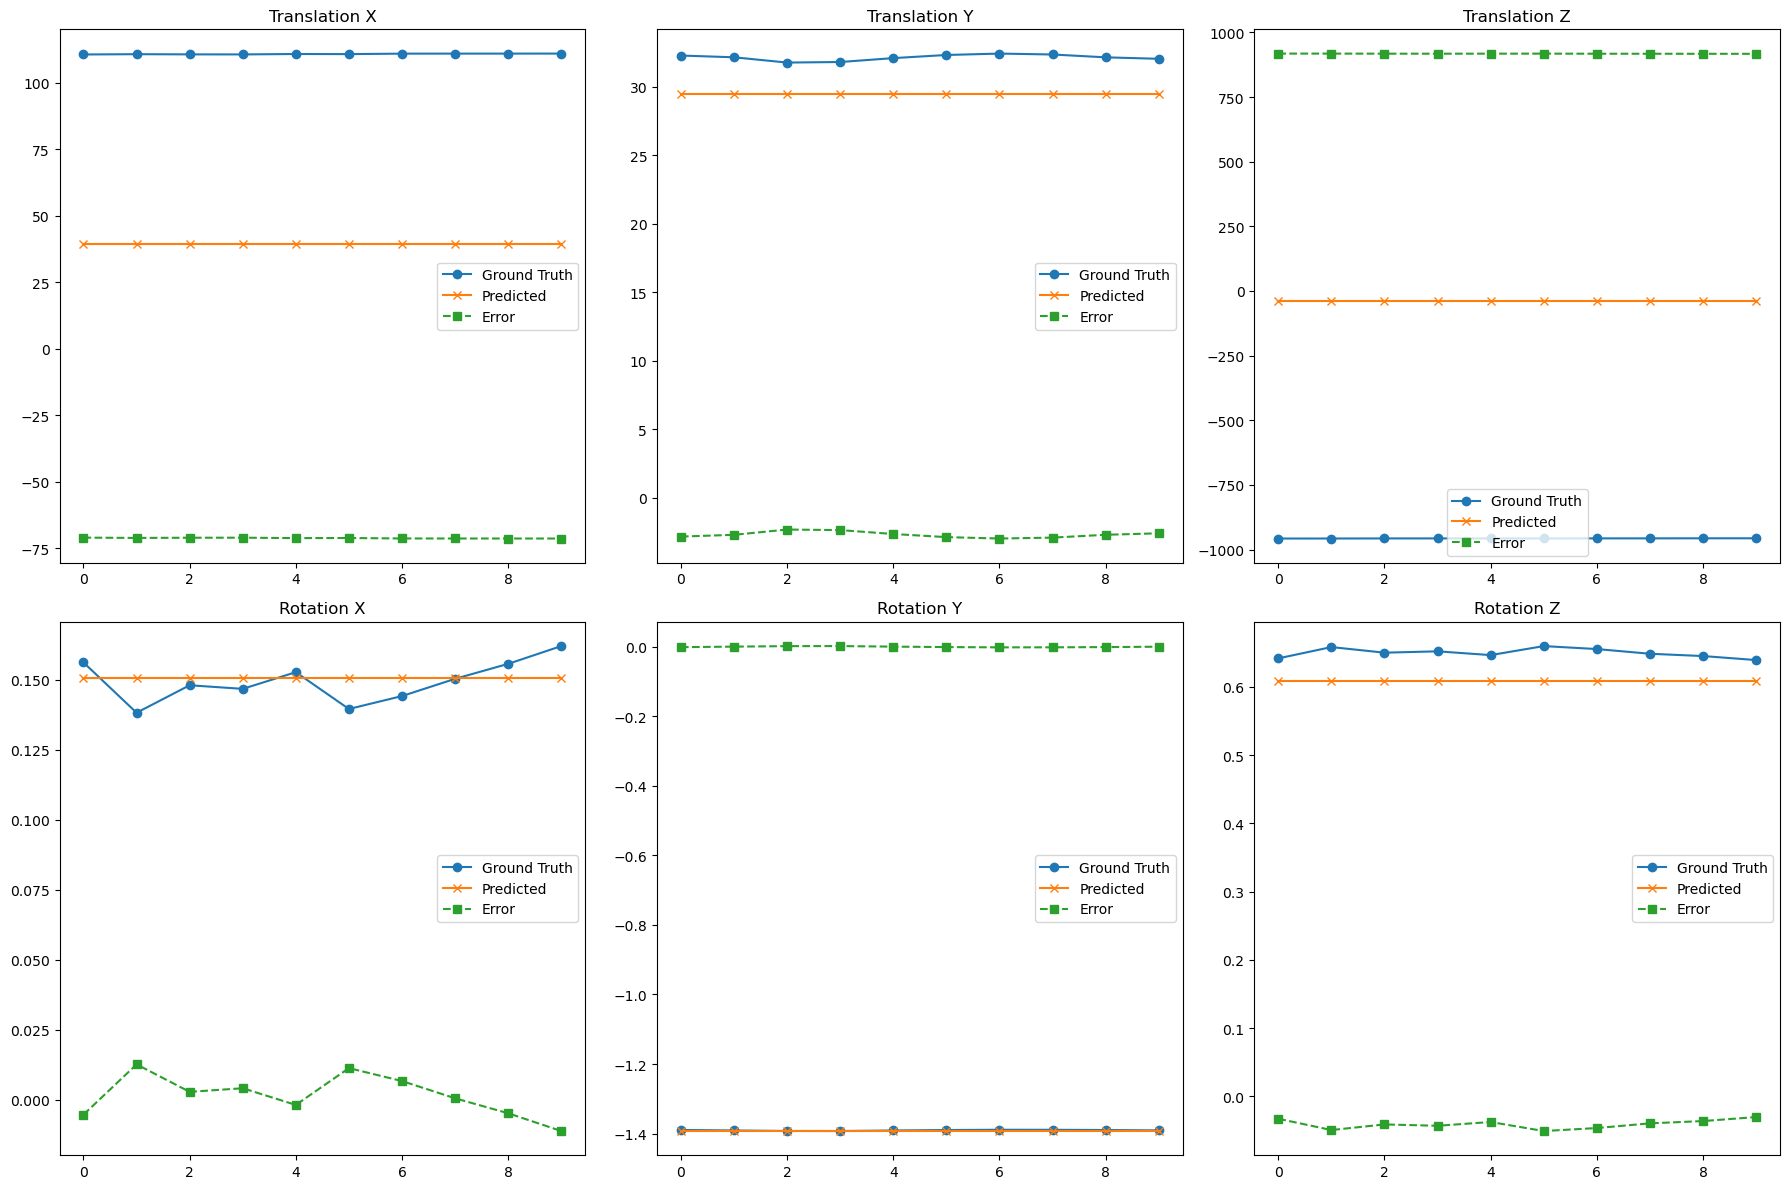

In [25]:
# %%

visualize_predictions(val_predictions, val_targets)

# %% [markdown]

## 8. Generate ground truth volume


In [ ]:
# %%


def plot_trajectory_and_poses(df, frame_stride=1, scale=10):
    # Extract optical tracker data
    positions = df[["ot_pos_x", "ot_pos_y", "ot_pos_z"]].values
    orientations = df[["ot_qw", "ot_qx", "ot_qy", "ot_qz"]].values

    # Create figure and 3D axis
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Plot trajectory
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], "b-", label="Trajectory")

    # Plot pose vectors
    for i in range(0, len(df), frame_stride):
        pos = positions[i]
        quat = orientations[i]

        # Convert quaternion to rotation matrix
        rot_matrix = Rotation.from_quat(quat).as_matrix()

        # Define coordinate axes
        axes = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, scale]])

        # Rotate and translate axes
        transformed_axes = rot_matrix @ axes.T + pos[:, np.newaxis]

        # Plot coordinate axes
        colors = ["r", "g", "b"]
        labels = ["X", "Y", "Z"]
        for j, (color, label) in enumerate(zip(colors, labels)):
            if i == 0:  # Only add label for the first iteration
                ax.quiver(
                    pos[0],
                    pos[1],
                    pos[2],
                    transformed_axes[0, j] - pos[0],
                    transformed_axes[1, j] - pos[1],
                    transformed_axes[2, j] - pos[2],
                    color=color,
                    label=label,
                )
            else:
                ax.quiver(
                    pos[0],
                    pos[1],
                    pos[2],
                    transformed_axes[0, j] - pos[0],
                    transformed_axes[1, j] - pos[1],
                    transformed_axes[2, j] - pos[2],
                    color=color,
                )

    # Set labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Ultrasound Frame Trajectory and Poses")

    # Add legend
    ax.legend()

    # Set aspect ratio to 'equal'
    ax.set_box_aspect(
        (np.ptp(positions[:, 0]), np.ptp(positions[:, 1]), np.ptp(positions[:, 2]))
    )

    # Show plot
    plt.tight_layout()
    plt.show()


# Usage
# Assuming 'df' is your DataFrame containing the optical tracker data
plot_trajectory_and_poses(df, frame_stride=1, scale=1)

In [ ]:
# %%


def reconstruct_ground_truth_volume(df, probe_specs, voxel_size=0.5):
    frames = df["frame"].values
    positions = df[["ot_pos_x", "ot_pos_y", "ot_pos_z"]].values
    orientations = df[["ot_qw", "ot_qx", "ot_qy", "ot_qz"]].values

    # Probe specifications
    depth = probe_specs["depth"]  # mm (axial direction)
    width = probe_specs["width"]  # mm (lateral direction)
    axial_res = probe_specs["axial_res"]  # mm
    lateral_res = probe_specs["lateral_res"]  # mm
    slice_thickness = probe_specs["slice_thickness"]  # mm (elevational direction)
    marker_to_probe_bottom = probe_specs["marker_to_probe_bottom"]  # mm

    # Calculate scaling factors
    axial_scale = depth / 1000  # mm per pixel in axial direction
    lateral_scale = width / 657  # mm per pixel in lateral direction

    # Calculate volume bounds
    rotations = Rotation.from_quat(orientations[:, [1, 2, 3, 0]])

    # Define frame corners in probe coordinates (y: axial, x: lateral, z: elevational)
    frame_corners = np.array(
        [[0, 0, 0], [width, 0, 0], [0, depth, 0], [width, depth, 0]]
    )

    # Transform to align with optical tracker coordinates
    transform_matrix = np.array(
        [
            [0, 0, -1],  # Tracker X -> -Probe Z (elevational)
            [1, 0, 0],  # Tracker Y -> Probe X (lateral)
            [0, -1, 0],  # Tracker Z -> -Probe Y (axial)
        ]
    )

    frame_corners = frame_corners @ transform_matrix.T

    # Add offset for marker to probe bottom
    frame_corners[:, 2] += marker_to_probe_bottom

    all_corners = (
        np.einsum("ijk,lk->ilj", rotations.as_matrix(), frame_corners)
        + positions[:, np.newaxis, :]
    )
    min_corner = np.min(all_corners.reshape(-1, 3), axis=0)
    max_corner = np.max(all_corners.reshape(-1, 3), axis=0)

    # Initialize volume
    volume_shape = np.ceil((max_corner - min_corner) / voxel_size).astype(int) + 1
    volume = np.zeros(volume_shape, dtype=np.float32)
    counts = np.zeros(volume_shape, dtype=np.int32)

    # Create coordinate grid for frames
    x, y = np.meshgrid(np.arange(657) * lateral_scale, np.arange(1000) * axial_scale)
    frame_coords = np.stack((x, y, np.zeros_like(x)), axis=-1)

    # Transform frame coordinates to align with optical tracker
    frame_coords = frame_coords @ transform_matrix.T
    frame_coords[:, :, 2] += marker_to_probe_bottom

    print("Reconstructing ground truth volume...")
    for i, (frame, position, orientation) in enumerate(
        tqdm(zip(frames, positions, orientations), total=len(frames))
    ):
        # Convert frame to grayscale
        frame = np.mean(frame, axis=-1).astype(np.float32)

        # Transform frame coordinates to world space
        rotation = Rotation.from_quat(orientation[[1, 2, 3, 0]]).as_matrix()
        world_coords = np.einsum("ij,klj->kli", rotation, frame_coords) + position

        # Calculate voxel coordinates
        voxel_coords = np.round((world_coords - min_corner) / voxel_size).astype(int)

        # Filter out-of-bounds voxels
        mask = np.all((voxel_coords >= 0) & (voxel_coords < volume_shape), axis=2)
        valid_voxels = voxel_coords[mask]
        valid_intensities = frame[mask]

        # Update volume and counts
        np.add.at(volume, tuple(valid_voxels.T), valid_intensities)
        np.add.at(counts, tuple(valid_voxels.T), 1)

    # Average intensities and handle zero counts
    mask = counts > 0
    volume[mask] /= counts[mask]

    return volume, min_corner, voxel_size


# Probe specifications
probe_specs = {
    "depth": 50,  # mm (axial direction)
    "width": 38,  # mm (lateral direction, assuming 19 mm on each side of the center)
    "axial_res": 0.5,  # mm
    "lateral_res": 2,  # mm
    "slice_thickness": 5,  # mm (elevational direction)
    "marker_to_probe_bottom": 10,  # mm (approximate, to be refined)
}

# Reconstruct ground truth volume
ground_truth_volume, volume_origin, voxel_size = reconstruct_ground_truth_volume(
    df, probe_specs, voxel_size=0.1  # lower voxel size corresponds to higher resolution
)

print(f"Ground truth volume shape: {ground_truth_volume.shape}")
print(f"Volume origin: {volume_origin}")
print(f"Voxel size: {voxel_size} mm")

In [ ]:
# %%

# Save the ground truth volume
np.save("ground_truth_volume.npy", np.flip(ground_truth_volume, axis=0))
print("Ground truth volume saved as 'ground_truth_volume.npy'")

# Save metadata
metadata = {
    "volume_origin": volume_origin.tolist(),
    "voxel_size": voxel_size,
    "probe_specs": probe_specs,
}
np.save("ground_truth_volume_metadata.npy", metadata)
print("Metadata saved as 'ground_truth_volume_metadata.npy'")

In [ ]:
# %%

ground_truth_volume.shape

# %% [markdown]

## Reconstruct predictions


In [ ]:
# %%


def euler_to_rotation_matrix(euler_angles):
    return Rotation.from_euler("xyz", euler_angles).as_matrix()


def reconstruct_predicted_volume(
    frames, predicted_transforms, probe_specs, voxel_size=0.5
):
    # Extract translations and rotations from predicted transforms
    translations = predicted_transforms[:, :3]
    rotations = [
        euler_to_rotation_matrix(euler) for euler in predicted_transforms[:, 3:]
    ]

    # Probe specifications
    depth = probe_specs["depth"]
    width = probe_specs["width"]
    marker_to_probe_bottom = probe_specs["marker_to_probe_bottom"]

    # Calculate scaling factors
    axial_scale = depth / frames.shape[1]
    lateral_scale = width / frames.shape[2]

    # Calculate volume bounds
    frame_corners = np.array(
        [[0, 0, 0], [width, 0, 0], [0, depth, 0], [width, depth, 0]]
    )
    transform_matrix = np.array(
        [
            [0, 0, -1],
            [1, 0, 0],
            [0, -1, 0],
        ]
    )
    frame_corners = frame_corners @ transform_matrix.T
    frame_corners[:, 2] += marker_to_probe_bottom

    all_corners = (
        np.einsum("ijk,lk->ilj", rotations, frame_corners)
        + translations[:, np.newaxis, :]
    )
    min_corner = np.min(all_corners.reshape(-1, 3), axis=0)
    max_corner = np.max(all_corners.reshape(-1, 3), axis=0)

    # Initialize volume
    volume_shape = np.ceil((max_corner - min_corner) / voxel_size).astype(int) + 1
    volume = np.zeros(volume_shape, dtype=np.float32)
    counts = np.zeros(volume_shape, dtype=np.int32)

    # Create coordinate grid for frames
    x, y = np.meshgrid(
        np.arange(frames.shape[2]) * lateral_scale,
        np.arange(frames.shape[1]) * axial_scale,
    )
    frame_coords = np.stack((x, y, np.zeros_like(x)), axis=-1)
    frame_coords = frame_coords @ transform_matrix.T
    frame_coords[:, :, 2] += marker_to_probe_bottom

    print("Reconstructing predicted volume...")
    for i, (frame, translation, rotation) in enumerate(
        tqdm(zip(frames, translations, rotations), total=len(frames))
    ):
        # Ensure frame is 2D (height x width)
        if frame.ndim == 3:
            frame = np.mean(frame, axis=-1).astype(np.float32)

        # Transform frame coordinates to world space
        world_coords = np.einsum("ij,klj->kli", rotation, frame_coords) + translation

        # Calculate voxel coordinates
        voxel_coords = np.round((world_coords - min_corner) / voxel_size).astype(int)

        # Filter out-of-bounds voxels
        mask = np.all((voxel_coords >= 0) & (voxel_coords < volume_shape), axis=2)
        valid_voxels = voxel_coords[mask]
        valid_intensities = frame[mask]

        # Update volume and counts
        np.add.at(volume, tuple(valid_voxels.T), valid_intensities)
        np.add.at(counts, tuple(valid_voxels.T), 1)

    # Average intensities and handle zero counts
    mask = counts > 0
    volume[mask] /= counts[mask]

    return volume, min_corner, voxel_size

In [ ]:
# %%

# Assuming you have already trained the model and have the validation dataset
model.eval()
all_frames = []
all_predictions = []

with torch.no_grad():
    for frames, imu_data, _ in val_loader:
        frames = frames.to(device)
        imu_data = imu_data.to(device)
        outputs = model(frames, imu_data)

        all_frames.append(frames.cpu().numpy())
        all_predictions.append(outputs.cpu().numpy())

all_frames = np.concatenate(all_frames, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

# Reconstruct the predicted volume
predicted_volume, volume_origin, voxel_size = reconstruct_predicted_volume(
    all_frames[:, 0],  # Use only the first frame of each sequence
    all_predictions[:, -1],  # Use the last prediction of each sequence
    probe_specs,
    voxel_size=0.1,
)

print(f"Predicted volume shape: {predicted_volume.shape}")
print(f"Volume origin: {volume_origin}")
print(f"Voxel size: {voxel_size} mm")

# Save the predicted volume
np.save("predicted_volume.npy", predicted_volume)
print("Predicted volume saved as 'predicted_volume.npy'")

# Save metadata
metadata = {
    "volume_origin": volume_origin.tolist(),
    "voxel_size": voxel_size,
    "probe_specs": probe_specs,
}
np.save("predicted_volume_metadata.npy", metadata)
print("Metadata saved as 'predicted_volume_metadata.npy'")